<a href="https://colab.research.google.com/github/grkidwell/max_charge_current/blob/master/max_charge_current_states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Battery Charger Design Optimization

###Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

plt.style.use('seaborn')

In [2]:
!git clone https://github.com/grkidwell/max_charge_current.git

Cloning into 'max_charge_current'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


###Functions and Classes

In [0]:
class Battery:
  
    def __init__(self,nstack=2,Whr=50, soc=0.3):
    
        self.nstack=nstack    # 2S, 3S, or 4S
        self.Whr=Whr       # Watt*hrs
        self.soc=soc          # state of charge.  0.01 to 1  (1% to 100%)
    
        self.vcellmin=3.0
        self.vcellnom=3.7
        self.vcellmax=4.35
    
        self.res=0.2  # Rbattery.  Path resistance, in Ohms, between the battery and charger output. Includes cell chemistry + busbar+connectors+cable+beads+pcb+BFET
    
        self.vmin=self.nstack*self.vcellmin
        self.vnom=self.nstack*self.vcellnom
        self.vmax=self.nstack*self.vcellmax
    
        self.Ahr=self.Whr/self.vnom   #Amp*hrs
    
        k=[3.542,1.391,6.43e-3,2.683]  #coefficients from Mathcad curve fit
        vcell=k[0]+k[1]*np.exp(-k[3]*(1-self.soc))-k[2]/(self.soc+.001)
    
        self.voltage=max(self.vmin,min(self.vmax, self.nstack*vcell))  #battery voltage has upper and lower clamp
    
        m=[17.5,1,0.1]  #coefficients from Mathcad curve fit
        self.irate= min(0.8,m[0]*(self.soc-m[1])**2 + m[2])
      
        self.ibat_cv = self.irate*self.Ahr   #load that the battery presents during cv charge mode (>80% SOC)
                                             #when charging curring decays to 10%, SOC=100 and charger should turn off BFET
      
      
 
class Adaptor:
  
    def __init__(self, power=60, voltage=20):
  
        Aclim_tol  = 0.05
    
        self.power=power*(1-Aclim_tol)
        self.voltage=voltage
    
        self.ilim=self.power*(1-Aclim_tol)/voltage

    
    
    
class Charger:
  
    def __init__(self, adaptor, battery, psystem=0, imax=7.5):  #adaptor and battery are objects
  
        Efficiency = 0.95
        self.pmax=adaptor.power*Efficiency
        self.imax=imax
        self.psys=psystem
    
        self.nstack=battery.nstack
        self.Whr=battery.Whr
        self.rbat=battery.res
      
        voltheadroom=0.3      #because of rbat, vsys must be > vbat to charge battery past soc=80%
        self.vsysmax=battery.vmax+voltheadroom
        self.vsysmin=battery.vmin     
        self.vbat=battery.voltage
        self.soc=battery.soc
    
      
        self.ichargemax=0.8*battery.Ahr       #charging current limited by battery and charger setting
      
        self.VRhot = False
      
      

    
        #def charger_state():
            #return [self.pout,self.icharge,self.vsys,self.iout]
    
        #4 loops - adaptor power, charge current, system voltage, max charger current
          
        def loop_adaptorpwr():
            '''
      Derive quadratic equation for Vsys at max output power.  roots will be complex when Psys>Padaptor.  
      but there should be a real solution for when negative current in battery simplest band aid is to flip 
      polarity of "c" quad coeff when this is the case or perhaps taking magnitude of complex root will give 
      the proper solution of Vsys.  need to verify.

      Vsys = Vbat + icharge*Rbat
           = Vbat + (iout-isys)*Rbat
           = Vbat + (Pmax/Vsys - Psys/Vsys)*Rbat
           = Vbat + (Pmax-Psys)/Vsys*Rbat
           
      Vsys^2 - Vbat*Vsys - (Pmax-Psys)Rbat = 0
            '''
            quadcoeff = [1, -self.vbat, -(self.pmax-self.psys)*self.rbat]
            vsys = max(np.roots(quadcoeff))
            iout = self.pmax/vsys
            icharge = (vsys - self.vbat)/self.rbat
            return [self.pmax,icharge,vsys,iout]
    
        def loop_chargecurrent():
            vsys = self.vbat + self.ichargemax*self.rbat
            pout = vsys*self.ichargemax + self.psys
            iout = pout/vsys
            return [pout,self.ichargemax,vsys,iout]

        def loop_voltage():
            icharge_rpath_limited = (self.vsysmax-self.vbat)/self.rbat
            if self.soc<0.8:  
                icharge = icharge_rpath_limited
                vsys = self.vsysmax
            else: #in CV charge mode (SOC>80%), the battery sets the charge current.  BIOS turns off charger when SOC =100%
                icharge = min(icharge_rpath_limited,battery.ibat_cv)
                vsys = self.vsysmax #self.vbat + icharge*self.rbat
            pout = vsys*icharge + self.psys
            iout = pout/vsys
            return [pout,icharge,vsys,iout]

        def loop_maxcurrent():
            '''
      Derive quadratic equation for Vsys at max output current
      
      Vsys = Vbat + icharge*Rbat
           = Vbat + (imax- Psys/Vsys)*Rbat
           = Vbat + imax*Rbat - Psys*Rbat/Vsys
           
      Vsys^2 - (Vbat+imax*Rbat)Vsys + Psys*Rbat = 0
            '''
            quadcoeff = [1, -(self.vbat+self.imax*self.rbat), self.psys*self.rbat]
            vsys = max(np.roots(quadcoeff))
            icharge = (vsys - self.vbat)/self.rbat
            pout = vsys*icharge + self.psys
            return [pout,icharge,vsys,self.imax]
        
        def min_error_idx(listoflists):
            def all_pos(list):
                flag=True
                for i in list:
                    if i < 0:
                        flag=False
                return flag
            min_error = min([min(errors) for errors in listoflists if all_pos(errors)])
            idx = [i for i, errors in enumerate(listoflists) if min(errors) == min_error][0]
            return idx
        
#Main program.  run all loops.  The loop with all positive errors AND the lowest error establishes the state of the charger

        if self.psys   > self.pmax:     #throttle system by setting VRhot. Will eventually want to allow power drawn from battery
            self.psys  = self.pmax
            self.VRhot = True
    
        charger_refs = [self.pmax,self.ichargemax,self.vsysmax,self.imax]
        loop_list    = [loop_adaptorpwr,loop_chargecurrent,loop_voltage,loop_maxcurrent] 
        
        charger_states_by_loop = [loop() for loop in loop_list]  #remember that each loop function returns a 4 element list of charger attributes/params
        loop_errors_by_loop = []
        for charger_state in charger_states_by_loop:
            loop_errors_by_loop.append([ref - charger_state[i] for i, ref in enumerate(charger_refs)])
        try:
            idx = min_error_idx(loop_errors_by_loop)
            charger_state_dominant = charger_states_by_loop[idx]
            if idx==3:
                self.VRhot = True
        except:
            print(loop_errors_by_loop)
        
        self.pout, self.icharge, self.vsys, self.iout = charger_state_dominant   
        
    def batterystate_vs_t(self, t):
        adaptor_pwr=self.pmax
        adaptor_state=Adaptor(power=adaptor_pwr)
          
        battery_stack=self.nstack
        battery_Whr=self.Whr
        
        system_power=self.psys
        
        charger_maxcurrent=self.imax
        
        time_end=t   #hrs
        timestep_hrs=1/60   
        soc_cum=self.soc
        time_list=np.arange(0,time_end,timestep_hrs)
        soclist=[]
        vbatlist=[]
        ichargelist=[]
        for t in time_list:
            battery_state=Battery(battery_stack,battery_Whr,soc=soc_cum)
            charger_state=Charger(adaptor_state,battery_state,psystem=system_power,imax=charger_maxcurrent)
            ichargerate = charger_state.icharge*1/battery_state.Ahr
            soc_cum = soc_cum + ichargerate*timestep_hrs
            soclist.append(soc_cum)
            vbatlist.append(battery_state.voltage)
            ichargelist.append(ichargerate)
        return [time_list,soclist,vbatlist,ichargelist]
    
    def time_to_charge(self):
        time_vs_t, soc_vs_t = self.batterystate_vs_t(10)[0:2]
        for i, soc in enumerate(soc_vs_t):
            idx = i
            if soc > 1:
                break
        return time_vs_t[idx]
            

In [4]:
charger1=Charger(Adaptor(power=90),Battery(soc=.01),psystem=50,imax=9.0)
charger1.time_to_charge()

3.2

In [5]:
timea=range(0,100,1)
timea


range(0, 100)

###Description


> The purpose of this model 

>Battery charger size can be reduced by clamping the maximum output current.   
> The adaptor's full power can only be utilized when the battery voltage has reached Vbattmin  
> Full adaptor power is acheived when the system voltage is high enough so that


> We know that for a given adaptor power, the maximum charging current will be inversely proportional to the minimum system voltage,   
>>>$Icharge_{max}={Padaptor\over Vsystem_{min}}$ &emsp; &emsp; &emsp; (1)


In [6]:
Battery(2,50,soc=.01).irate

0.8

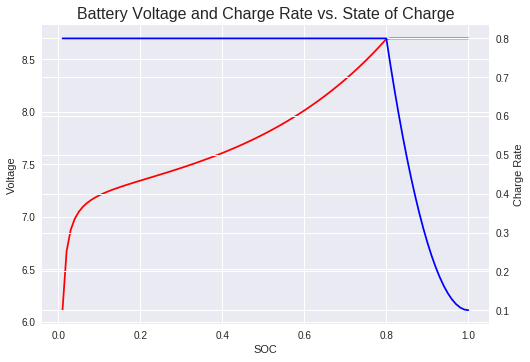

In [7]:
#@title
socvar = np.arange(.01,1.01,.01)
vbatlist = []
ibatlist = []
for i in socvar:
  vbatlist.append(Battery(2,50,soc=i).voltage) 
  ibatlist.append(Battery(2,50,soc=i).irate)
fig, ax1 = plt.subplots()

ax1.plot(socvar,vbatlist,color='r')
ax2 = ax1.twinx()

ax2.plot(socvar,ibatlist,color='b')

ax1.set_xlabel('SOC')
ax1.set_ylabel('Voltage')
ax2.set_ylabel('Charge Rate')
plt.title("Battery Voltage and Charge Rate vs. State of Charge" , fontsize=16)
plt.show()

In [0]:
ichargermax=7
padaptor=60


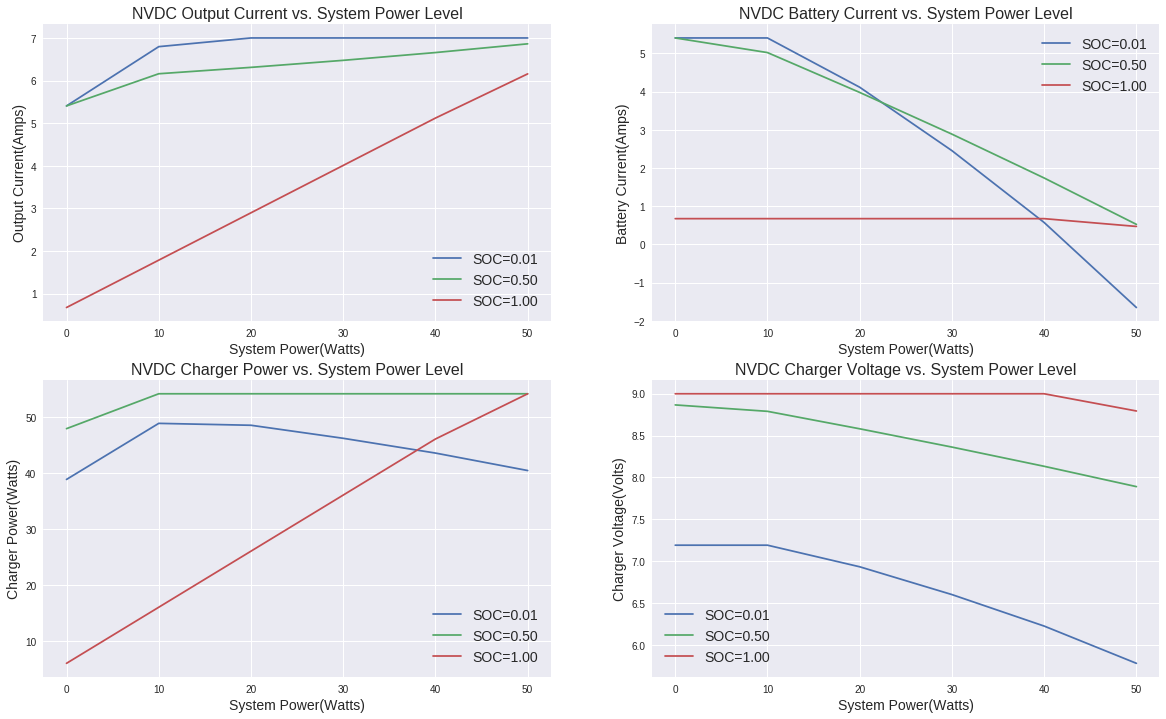

In [9]:
#@title
soclist = [0.01, 0.5, 1.0]
syspwr = np.arange(0,padaptor,10)
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
  
for s in soclist:
  chargercurrent = []
  batterycurrent = []
  chargerpower = []
  chargervoltage = []
  for p in syspwr:
    chargercurrent.append(Charger(Adaptor(padaptor,20),Battery(2,50,soc=s),psystem=p, imax=ichargermax).iout) 
    batterycurrent.append(Charger(Adaptor(padaptor,20),Battery(2,50,soc=s),psystem=p, imax=ichargermax).icharge)
    chargerpower.append(Charger(Adaptor(padaptor,20),Battery(2,50,soc=s),psystem=p, imax=ichargermax).pout) 
    chargervoltage.append(Charger(Adaptor(padaptor,20),Battery(2,50,soc=s),psystem=p, imax=ichargermax).vsys)
  ax1.plot(syspwr,chargercurrent,label="SOC=%3.2f" % (s))
  ax2.plot(syspwr,batterycurrent,label="SOC=%3.2f" % (s))
  ax3.plot(syspwr,chargerpower,label="SOC=%3.2f" % (s))
  ax4.plot(syspwr,chargervoltage,label="SOC=%3.2f" % (s))
ax1.set_xlabel("System Power(Watts)", size=14)
ax1.set_ylabel("Output Current(Amps)", size=14)
ax1.set_title("NVDC Output Current vs. System Power Level" , fontsize=16)
ax1.legend(ncol=1, loc='lower right', fontsize=14)
ax2.set_xlabel("System Power(Watts)", size=14)
ax2.set_ylabel("Battery Current(Amps)", size=14)
ax2.set_title("NVDC Battery Current vs. System Power Level" , fontsize=16)
ax2.legend(ncol=1, loc='upper right', fontsize=14)
ax3.set_xlabel("System Power(Watts)", size=14)
ax3.set_ylabel("Charger Power(Watts)", size=14)
ax3.set_title("NVDC Charger Power vs. System Power Level" , fontsize=16)
ax3.legend(ncol=1, loc='lower right', fontsize=14)
ax4.set_xlabel("System Power(Watts)", size=14)
ax4.set_ylabel("Charger Voltage(Volts)", size=14)
ax4.set_title("NVDC Charger Voltage vs. System Power Level" , fontsize=16)
ax4.legend(ncol=1, loc='lower left', fontsize=14)

plt.show()

In [10]:
charger=Charger(Adaptor(90,20),Battery(2,50,soc=.01),psystem=30, imax=7.0)
charger.time_to_charge()

2.8166666666666664

In [0]:
batstate_array=charger.batterystate_vs_t(5)

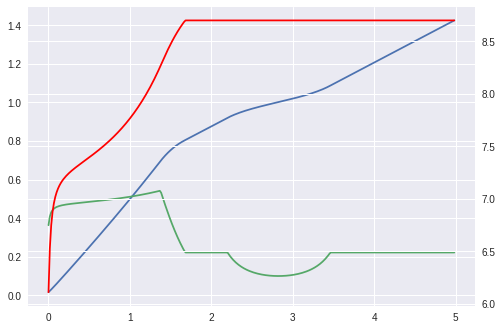

In [12]:
fig, ax1 = plt.subplots()


ax1.plot(batstate_array[0],batstate_array[1])
ax1.plot(batstate_array[0],batstate_array[3])
ax2 = ax1.twinx()
ax2.plot(batstate_array[0],batstate_array[2], color='red')
plt.show()


> When the NB is off, all of the adaptor power is directed toward charging the battery and charger current is limited by the EC

> When the NB is on, the EC may need to throttle the system to keep the charger current within design specs.   


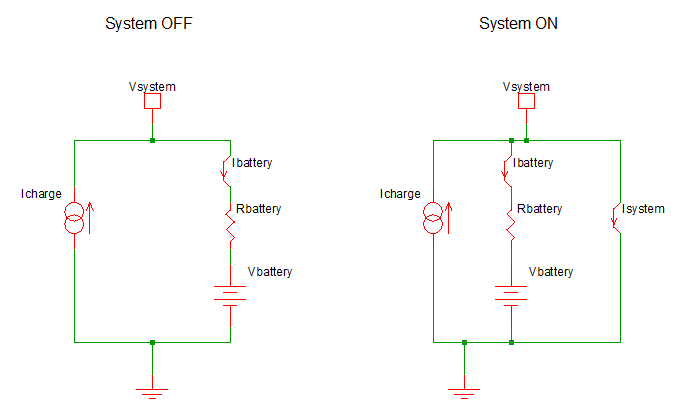

In [14]:
#@title
Image('max_charge_current/circuit_diagram.png', height=400,width=600)

###Parameters

###Results

### Graphs